In [7]:
import os
import pickle
import random
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.applications.efficientnet_v2 import (
    EfficientNetV2L,
    preprocess_input,
)
from tensorflow.keras.preprocessing import image as tf_image
from PIL import Image
from IPython.display import display

In [8]:
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = tf_image.load_img(img_path)
    img_array = tf_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array


def extract_features(img_path, model):
    img_array = load_and_preprocess_image(img_path)
    features = model.predict(img_array)
    return features


def find_similar_logos(logo_path, database, model, threshold=0.9):
    logo_features = extract_features(logo_path, model)
    similar_logos = []

    for img_path, features in database.items():
        similarity = cosine_similarity(logo_features, features)
        if similarity >= threshold:
            similar_logos.append((img_path, similarity))

    return sorted(similar_logos, key=lambda x: x[1], reverse=True)[:5]


In [11]:
efficientnet_model = EfficientNetV2L(
    weights="imagenet", include_top=False, pooling="avg"
)

logodatabase_file_path = "data/logo_database.pkl"
data_folder = "/Users/konstantinp/Downloads/L3Ddata/images"

# Check if the file exists
if os.path.exists(logodatabase_file_path):
    print(f"The file '{logodatabase_file_path}' exists.")
else:
    print(f"The file '{logodatabase_file_path}' does not exist.")
    logo_database = {}
    for file_name in os.listdir(data_folder):
        file_path = os.path.join(data_folder, file_name)

        # Check if the file is an image (assuming only JPEG and PNG formats)
        if file_path.lower().endswith((".jpg", ".jpeg", ".png")):
            logo_database[file_path] = extract_features(file_path, efficientnet_model)

    with open(logodatabase_file_path, "wb") as file:
        pickle.dump(logo_database, file)
    print("Logo database saved to logo_database.pkl")


loaded_logo_database = {}
with open(logodatabase_file_path, "rb") as file:
    loaded_logo_database = pickle.load(file)

print("Logo database loaded from logo_database.pkl")

The file 'data/logo_database.pkl' exists.
Logo database loaded from logo_database.pkl


In [13]:
all_files = os.listdir(data_folder)

# Filter out only image files (assuming only JPEG and PNG formats)
image_files = [
    file for file in all_files if file.lower().endswith((".jpg", ".jpeg", ".png"))
]

1/1 [==============================] - 0s 97ms/step


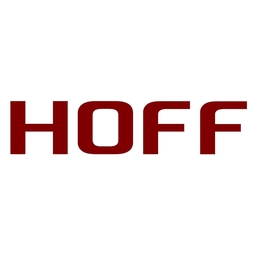

Finding similar logo to /Users/konstantinp/Downloads/L3Ddata/images/24c63245-0b09-4e5f-8dcb-3dace54f43cf.jpg
Logo: /Users/konstantinp/Downloads/L3Ddata/images/24c63245-0b09-4e5f-8dcb-3dace54f43cf.jpg, Similarity: 0.9999996423721313


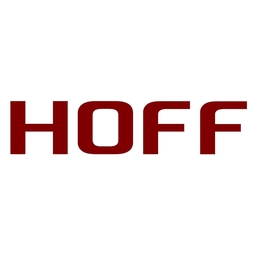

Logo: /Users/konstantinp/Downloads/L3Ddata/images/ecd4f0f2-ff67-4fe1-b718-6201d25a9265.jpg, Similarity: 0.9179283380508423


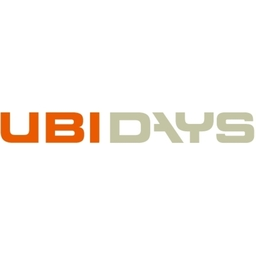

Logo: /Users/konstantinp/Downloads/L3Ddata/images/7195bccc-c84a-460d-8de8-bf6f47f7ac8d.jpg, Similarity: 0.9018944501876831


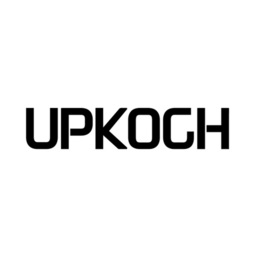

In [23]:
# Select a random image file
target_logo_file = random.choice(image_files)
target_logo_path = os.path.join(data_folder, target_logo_file)
# target_logo_path = "target1.jpg"
# Find similar logos to the target logo
similar_logos = find_similar_logos(
    target_logo_path, loaded_logo_database, efficientnet_model
)

target_image = Image.open(target_logo_path)
display(target_image)
# Print the similar logos and their similarity scores
print(f"Finding similar logo to {target_logo_path}")
for logo_path, similarity in similar_logos:
    print(f"Logo: {logo_path}, Similarity: {similarity[0][0]}")
    image = Image.open(logo_path)
    display(image)
    
